## CCA
#### Imports

In [1]:
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import scipy.stats as sts 
from sklearn.decomposition import PCA
from statsmodels.multivariate.cancorr import CanCorr

from helpers import *
import cca_helpers

In [2]:
trial_colors = {'ah':'mediumblue',
               'wh':'forestgreen',
               'wm':'crimson',
               'fa':'k',
               'cr':'dimgray'}

#### Get behavioural and neural data

In [3]:
data_path =  '../data/'

verbose = True

# Load trial data
fname = 'ab042_trial_data.csv'
trial_df = pd.read_csv(os.path.join(data_path,fname))
trial_df.head()

trial_type_list = ['ah', 'wh','wm','fa','cr']
if verbose:
    for trial_type in trial_type_list:
        print('Trial type, {}, #trials = {}'.format(trial_type, sum(trial_df[trial_type])))
        

# Load neuron data for list of areas
fname = 'ab042_cluster_spike_times.csv'
neuron_df = pd.read_csv(os.path.join(data_path,fname))
areas = np.unique(neuron_df.area, return_counts=True)
area_list = areas[0]

if verbose:
    print(areas)

# Load spike count data

fname = 'ab042_spikes_dense.npy'
spike_array = np.load(os.path.join(data_path,fname))
print(spike_array.shape)


Trial type, ah, #trials = 83
Trial type, wh, #trials = 42
Trial type, wm, #trials = 140
Trial type, fa, #trials = 36
Trial type, cr, #trials = 211
(array(['DLS', 'DS', 'OFC', 'Thalamus', 'nS1', 'tjM1', 'wM2', 'wS1'],
      dtype=object), array([135,  30,  72, 139, 121, 166, 126,  58]))
(847, 512, 401)


#### Get per-area matrices

In [4]:

all_psths = {}

for trial_type in trial_type_list:
    all_psths[trial_type] = {}
    trial_indices = trial_df[trial_df[trial_type]==1].index.values

    for area in area_list:
        neuron_indices = neuron_df[neuron_df.area==area].index.values

        spike_array_sub = spike_array[neuron_indices][:,trial_indices,:]
        all_psths[trial_type][area] = spike_array_sub

if verbose:
    for area in all_psths["ah"].keys():
        print(area, all_psths["ah"][area].shape)

DLS (135, 83, 401)
DS (30, 83, 401)
OFC (72, 83, 401)
Thalamus (139, 83, 401)
nS1 (121, 83, 401)
tjM1 (166, 83, 401)
wM2 (126, 83, 401)
wS1 (58, 83, 401)


#### PSTHs

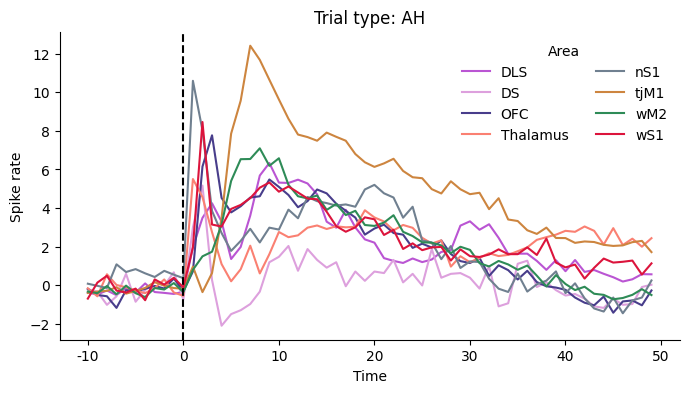

In [5]:
trial_start_idx = 200
pre_win = 10
start_idx = trial_start_idx - pre_win
post_win = 50
stop_idx = trial_start_idx + post_win

#print(trial_start_idx, start_idx, stop_idx)
for trial_type in trial_type_list:

    if trial_type != 'ah':
        continue
        
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    ax.spines[['right', 'top']].set_visible(False)

    for area in area_list:
        spike_array_area = all_psths[trial_type][area] 
        spike_array_sub_bas = spike_array_area[:,:,0:100]
        baseline = np.mean(spike_array_sub_bas)
        spike_array_area_correct = spike_array_area - baseline
        mean_spike_rate = (np.mean(spike_array_area_correct, axis=(0,1))) / 0.01
        mean_spike_rate = mean_spike_rate[start_idx:stop_idx]
        
        # Plot
        ax.plot(mean_spike_rate,
                color=get_area_color(area),
                label=area)


    # Legend
    ax.set_title('Trial type: {}'.format(trial_type.upper()))
    ax.axvline(x=trial_start_idx - start_idx, ls='--',c='k')
    x_ticks = np.arange(0, pre_win+post_win+1) 
    x_ticks = x_ticks[::10]
    x_labels = np.arange(-pre_win, +post_win+1)
    x_labels = x_labels[::10]
    #print(x_ticks, x_labels)
    ax.set_xticks(ticks=x_ticks,
                 labels=x_labels)
    ax.set_xlabel('Time')
    ax.set_ylabel('Spike rate')
    plt.legend(title='Area', frameon=False, ncol=2)
    
    #ax.xaxis.set_major_locator(MaxNLocator(integer=True))


#### PSTH smoothed

(60,)
(60,)
(60,)
(60,)
(60,)
(60,)
(60,)
(60,)


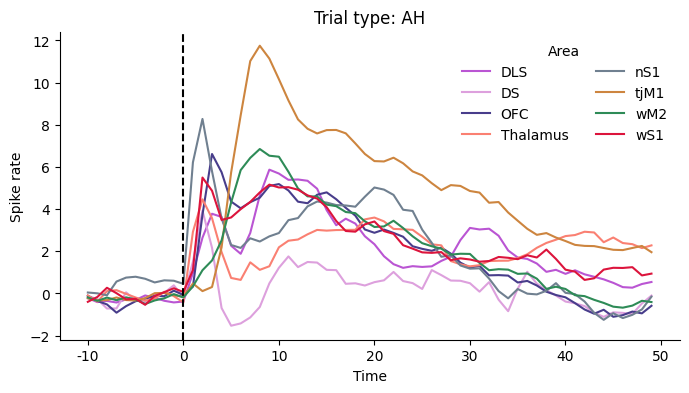

In [6]:
smooth = True


trial_start_idx = 200
pre_win = 10
start_idx = trial_start_idx - pre_win
post_win = 50
stop_idx = trial_start_idx + post_win

#print(trial_start_idx, start_idx, stop_idx)
for trial_type in trial_type_list:

    if trial_type != 'ah':
        continue
        
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    ax.spines[['right', 'top']].set_visible(False)

    for area in area_list:
        spike_array_area = all_psths[trial_type][area] 
        spike_array_sub_bas = spike_array_area[:,:,0:100]
        baseline = np.mean(spike_array_sub_bas)
        spike_array_area_correct = spike_array_area - baseline
        mean_spike_rate = (np.mean(spike_array_area_correct, axis=(0,1))) / 0.01
        mean_spike_rate = mean_spike_rate[start_idx:stop_idx]
        
        # Plot
        print(mean_spike_rate.shape)
        if smooth:
            mean_spike_rate = halfgaussian_filter1d(mean_spike_rate, sigma=1)
            
        ax.plot(mean_spike_rate,
                color=get_area_color(area),
                label=area)


    # Legend
    ax.set_title('Trial type: {}'.format(trial_type.upper()))
    ax.axvline(x=trial_start_idx - start_idx, ls='--',c='k')
    x_ticks = np.arange(0, pre_win+post_win+1) 
    x_ticks = x_ticks[::10]
    x_labels = np.arange(-pre_win, +post_win+1)
    x_labels = x_labels[::10]
    #print(x_ticks, x_labels)
    ax.set_xticks(ticks=x_ticks,
                 labels=x_labels)
    ax.set_xlabel('Time')
    ax.set_ylabel('Spike rate')
    plt.legend(title='Area', frameon=False, ncol=2)
    

(126, 83, 401)


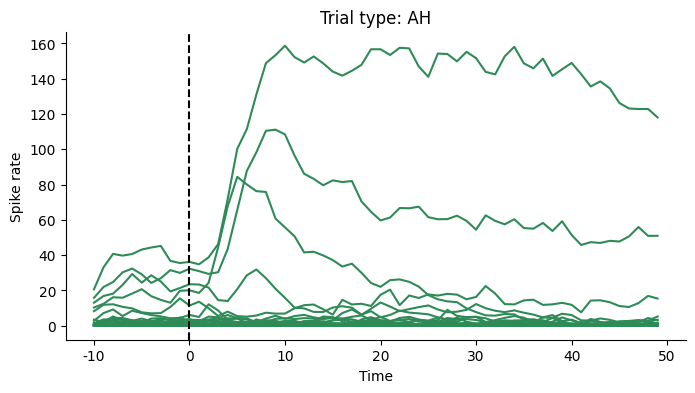

In [7]:
smooth = True


trial_start_idx = 200
pre_win = 10
start_idx = trial_start_idx - pre_win
post_win = 50
stop_idx = trial_start_idx + post_win

#print(trial_start_idx, start_idx, stop_idx)
for trial_type in trial_type_list:

    if trial_type != 'ah':
        continue
        
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    ax.spines[['right', 'top']].set_visible(False)

    for area in area_list:
        if area != 'wM2':
            continue
            
        spike_array_area = all_psths[trial_type][area] 
        spike_array_sub_bas = spike_array_area[:,:,0:100]
        baseline = np.mean(spike_array_sub_bas)
        print(spike_array_area.shape)
        spike_array_area_correct = spike_array_area - baseline
        
        for t_idx in range(spike_array_area.shape[0])[::5]:
            
            trial_spikes = np.mean(spike_array_area[t_idx,:,:], axis=0) / 0.01
            trial_spikes = trial_spikes[start_idx:stop_idx]
        
            # Plot
            if smooth:
                trial_spikes = halfgaussian_filter1d(trial_spikes, sigma=1)

            ax.plot(trial_spikes,
                    color=get_area_color(area),
                    label=area)


    # Legend
    ax.set_title('Trial type: {}'.format(trial_type.upper()))
    ax.axvline(x=trial_start_idx - start_idx, ls='--',c='k')
    x_ticks = np.arange(0, pre_win+post_win+1) 
    x_ticks = x_ticks[::10]
    x_labels = np.arange(-pre_win, +post_win+1)
    x_labels = x_labels[::10]
    ax.set_xticks(ticks=x_ticks,
                 labels=x_labels)
    ax.set_xlabel('Time')
    ax.set_ylabel('Spike rate')
    #plt.legend(title='Area', frameon=False, ncol=2)
    

#### Smooth and select data slices, and reshape in 2D (trial concat.)

In [8]:
area_1 = 'tjM1'
area_2 = 'wM2'
trial_type = 'ah'

trial_start_idx = 200
pre_win = 10
start_idx = trial_start_idx - pre_win
post_win = 50
stop_idx = trial_start_idx + post_win

kernal_sigma = 1

# Area 1
spike_array_area_1 = all_psths[trial_type][area_1] 
print(spike_array_area_1.shape)
spike_array_area_smooth_1 = []

# Smooth each neuron/trial independently
for neur_idx in range(spike_array_area_1.shape[0]):
    spike_array_trial = []
    for t_idx in range(spike_array_area_1.shape[1]):
        trial_spikes = spike_array_area_1[neur_idx,t_idx,start_idx:stop_idx]
        trial_spk = halfgaussian_filter1d(trial_spikes, sigma=1)
        spike_array_trial.append(trial_spk)
    spike_array_area_smooth_1.append(spike_array_trial)

# Make as array
spike_array_area_smooth_1=np.asarray(spike_array_area_smooth_1)
print(spike_array_area_smooth_1.shape)

# Area 2
spike_array_area_2 = all_psths[trial_type][area_2] 
print(spike_array_area_2.shape)
spike_array_area_smooth_2 = []

# Smooth each neuron/trial independently
for neur_idx in range(spike_array_area_2.shape[0]):
    spike_array_trial = []
    for t_idx in range(spike_array_area_2.shape[1]):
        trial_spikes = spike_array_area_2[neur_idx,t_idx,start_idx:stop_idx]
        trial_spk = halfgaussian_filter1d(trial_spikes, sigma=1)
        spike_array_trial.append(trial_spk)
    spike_array_area_smooth_2.append(spike_array_trial)

# Make as array
spike_array_area_smooth_2=np.asarray(spike_array_area_smooth_2)
print(spike_array_area_smooth_2.shape)


n_trials = spike_array_area_smooth_2.shape[1]

(166, 83, 401)
(166, 83, 60)
(126, 83, 401)
(126, 83, 60)


In [9]:
spike_array_area_1.shape

(166, 83, 401)

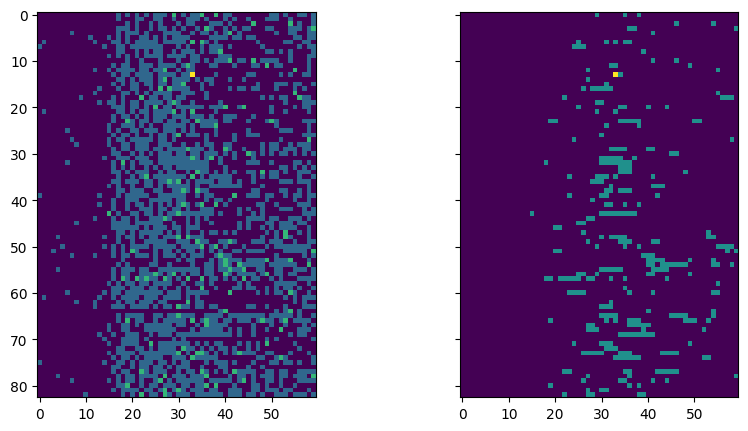

In [10]:
neur_idx=10
fig, axs = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
axs[0].imshow(spike_array_area_1[neur_idx,:,start_idx:stop_idx])
axs[1].imshow(spike_array_area_smooth_1[neur_idx,:,:])

#### Reshape and center data

In [11]:

X_1 = spike_array_area_smooth_1.reshape(spike_array_area_smooth_1.shape[0], -1)
print(X_1.shape)
X_2 = spike_array_area_smooth_2.reshape(spike_array_area_smooth_2.shape[0], -1)
print(X_2.shape)

X_1 = X_1 - X_1.mean(axis=1)[:,np.newaxis]
X_2 = X_2 - X_2.mean(axis=1)[:,np.newaxis]


(166, 4980)
(126, 4980)


### Align using CCA

In [12]:
n_pcs=30
axes_area_1, axes_area_2, cc = cca_helpers.align(X_1.T,X_2.T, m=n_pcs)
cc = np.asarray(cc)
print(axes_area_1.shape, axes_area_2.shape, cc.shape)

(166, 30) (126, 30) (30,)


Text(0, 0.5, 'Canonical correlation')

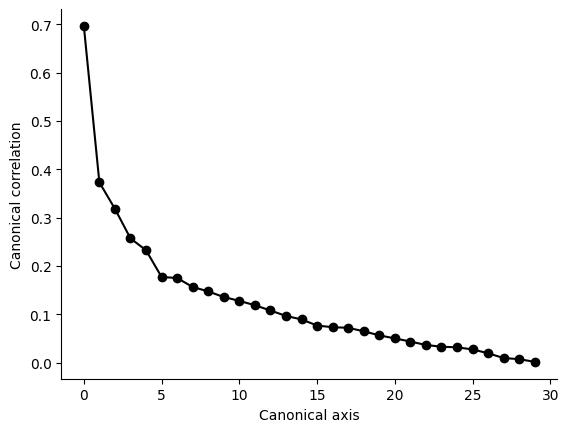

In [13]:
fig, ax = plt.subplots(1,1)
remove_top_right_frame(ax)

ax.plot(cc, marker='o', c='k')
ax.set_xlabel('Canonical axis')
ax.set_ylabel('Canonical correlation')

(4980, 30) (4980, 30)
(83, 60, 30) (83, 60, 30)


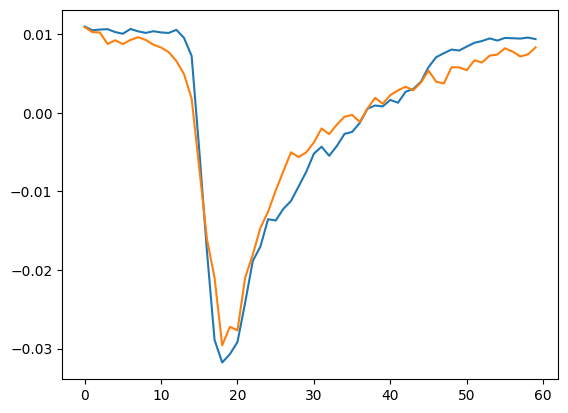

In [29]:
A_1 = X_1.T @ axes_area_1
A_2 = X_2.T @ axes_area_2
print(A_1.shape, A_2.shape)

A_1_trials = A_1.reshape(n_trials, -1, A_1.shape[1])
A_2_trials = A_2.reshape(n_trials, -1, A_2.shape[1])
print(A_1_trials.shape, A_2_trials.shape)

plt.plot(np.mean(A_1_trials, axis=0)[:,0])
plt.plot(np.mean(A_2_trials, axis=0)[:,0])

#### Plot mean over trials

In [32]:
A_1_trials.shape

(83, 60, 30)

In [15]:
A_1_trials_mean = np.mean(A_1_trials,axis=0)
A_2_trials_mean = np.mean(A_2_trials,axis=0)
print(A_1_trials_mean.shape, A_2_trials_mean.shape)

(60, 30) (60, 30)


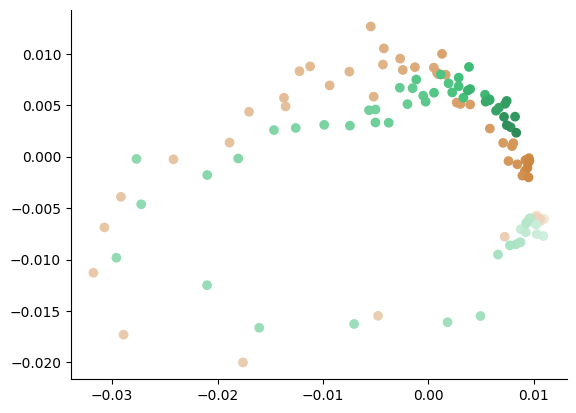

In [33]:
fig, ax = plt.subplots(1,1)
remove_top_right_frame(ax)

ax.scatter(A_1_trials_mean[:,0], 
          A_1_trials_mean[:,1], 
          #A_1_trials_mean[:,2],
          color = return_timebin_cmap(get_area_color(area_1), 60))

ax.scatter(A_2_trials_mean[:,0], 
          A_2_trials_mean[:,1], 
          #A_2_trials_mean[:,2],
          color = return_timebin_cmap(get_area_color(area_2), 60))




In [ ]:
fig, ax = plt.subplots(1,1)
remove_top_right_frame(ax)

for t_idx in range(10):
    ax.scatter(A_1_trials[:,0], 
              A_1_trials_mean[:,1], 
              #A_1_trials_mean[:,2],
              color = return_timebin_cmap(get_area_color(area_1), 60))

    ax.scatter(A_2_trials_mean[:,0], 
              A_2_trials_mean[:,1], 
              #A_2_trials_mean[:,2],
              color = return_timebin_cmap(get_area_color(area_2), 60))




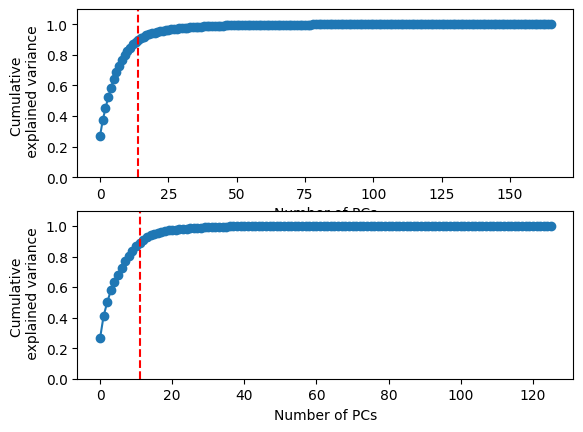

In [18]:
pca_tjm1 = PCA()
pca_tjm1.fit(X_1)

pca_dls = PCA()
pca_dls.fit(X_2)

fig, axs = plt.subplots(2,1)
for ax in axs.flat:
    ax.set_ylim(0,1.1)
    ax.set_ylabel('Cumulative \n explained variance')
    ax.set_xlabel('Number of PCs')
    
axs[0].plot(np.cumsum(pca_tjm1.explained_variance_ratio_), marker="o")
axs[0].axvline(np.argmin(np.abs(np.cumsum(pca_tjm1.explained_variance_ratio_)-0.9)), linestyle="--", c="red")
axs[1].plot(np.cumsum(pca_dls.explained_variance_ratio_), marker="o")
axs[1].axvline(np.argmin(np.abs(np.cumsum(pca_dls.explained_variance_ratio_)-0.9)), linestyle="--", c="red")


In [19]:
n_latents = 20
pca_tjm1 = PCA(n_components=n_latents) # TODO: cross/validate train and test
proj_tjm1 = pca_tjm1.fit_transform(mc_tjm1.T)

pca_dls = PCA(n_components=n_latents)
proj_dls = pca_dls.fit_transform(mc_dls.T)

NameError: name 'mc_tjm1' is not defined

In [ ]:
print(proj_tjm1.shape)
print(proj_dls.shape)

In [ ]:
re_proj_tjm1 = proj_tjm1.reshape(-1,n_trials, n_latents)
re_proj_dls = proj_dls.reshape(-1,n_trials, n_latents)
print(re_proj_tjm1.shape)

In [ ]:
cc = CanCorr(proj_tjm1, proj_dls)

In [ ]:
ccdims1 = cc.y_cancoef
ccdims2 = cc.x_cancoef

In [ ]:
print(ccdims1.shape)
print(ccdims2.shape)

In [ ]:
cc.cancorr

In [ ]:
plt.plot(cc.cancorr)

In [ ]:
#cc = CanCorr(proj_tjm1, proj_dls)

ccdims1 = cc.y_cancoef
ccdims2 = cc.x_cancoef

cc_proj_tjm1 = proj_tjm1 @ ccdims1
cc_proj_dls = proj_dls @ ccdims2


print(ccend_proj_tjm1.shape)
print(ccexog_proj_dls.shape)

In [ ]:
cc_proj_tjm1_trials = cc_proj_tjm1.reshape(-1,n_trials,n_latents)
cc_proj_dls_trials = cc_proj_dls.reshape(-1,n_trials,n_latents)

print(cc_proj_tjm1_trials.shape, cc_proj_dls_trials.shape)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,2))
ax.plot(cc_proj_tjm1_trials[:,:,0].mean(axis=1))
ax.plot(cc_proj_dls_trials[:,:,0].mean(axis=1))
ax.set_ylabel('Canonical dimension 1')
ax.set_xlabel('Time bins (trial-averaged)')

n_cc_dims = 5
fig, axs = plt.subplots(n_cc_dims, n_cc_dims, figsize=(10,10), sharex=True, sharey=True)

for idx in range(n_cc_dims):
    axs[idx,idx].set_xlabel('C. dim. {}'.format(idx))
    axs[idx,idx].set_ylabel('C. dim. {}'.format(idx))
    
    corr_coeff = sts.pearsonr(cc_proj_tjm1_trials[:,:,idx].mean(axis=1), 
                              cc_proj_dls_trials[:,:,idx].mean(axis=1))[0]
    axs[idx,idx].set_title(r'$r = {:.3f}$'.format(corr_coeff))

    axs[idx,idx].scatter(x=cc_proj_tjm1_trials[:,:,idx].mean(axis=1),
              y=cc_proj_dls_trials[:,:,idx].mean(axis=1),
              s=1)



In [ ]:
all_corrs = {}
for i in range(20):
    c_corr = np.corrcoef(cc_proj_tjm1_trials[:,:,i].mean(axis=1), cc_proj_dls_trials[:,:,i].mean(axis=1))[0,1]
    all_corrs[i] = c_corr
    
fig, ax = plt.subplots()
ax.plot(all_corrs.keys(), all_corrs.values(), marker="o")

In [ ]:
%matplotlib inline

cc_tjm1 = cc_proj_tjm1_trials[:,:,:3]

print(cc_tjm1.shape)


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)

ax.set_title('Unaligned - tjM1')

im = ax.scatter(re_proj_tjm1[:,0].mean(axis=1),
       re_proj_tjm1[:,1].mean(axis=1),
               c=np.linspace(0.2,0.8,301), s=5)

ax = fig.add_subplot(1,2,2)
ax.set_title('Aligned - tjM1')

im = ax.scatter(cc_tjm1[:,0].mean(axis=1),
       cc_tjm1[:,1].mean(axis=1),
                c=np.linspace(0.2,0.8,301), s=5)


cc_dls = cc_proj_dls_trials[:,:,:3]


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)

ax.set_title('Unaligned - DLS')

im = ax.scatter(re_proj_dls[:,0].mean(axis=1),
       re_proj_dls[:,1].mean(axis=1),
               c=np.linspace(0.2,0.8,301), s=5)

ax = fig.add_subplot(1,2,2)
ax.set_title('Aligned - DLS')

im = ax.scatter(cc_dls[:,0].mean(axis=1),
       cc_dls[:,1].mean(axis=1),
                c=np.linspace(0.2,0.8,301), s=5)

In [ ]:
%matplotlib inline

cc_tjm1 = cc_proj_tjm1_trials[:,:,:3]

print(cc_tjm1.shape)


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1,projection="3d")

ax.set_title('Unaligned - tjM1')

im = ax.scatter(re_proj_tjm1[:,0].mean(axis=1),
       re_proj_tjm1[:,1].mean(axis=1),
       re_proj_tjm1[:,2].mean(axis=1),
               c=np.linspace(0.2,0.8,301))

ax = fig.add_subplot(1,2,2,projection="3d")
ax.set_title('Aligned - tjM1')

im = ax.scatter(cc_tjm1[:,0].mean(axis=1),
       cc_tjm1[:,1].mean(axis=1),
       cc_tjm1[:,2].mean(axis=1), 
                c=np.linspace(0.2,0.8,301))


cc_dls = cc_proj_dls_trials[:,:,:3]


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1,projection="3d")

ax.set_title('Unaligned - DLS')

im = ax.scatter(re_proj_dls[:,0].mean(axis=1),
       re_proj_dls[:,1].mean(axis=1),
       re_proj_dls[:,2].mean(axis=1),
               c=np.linspace(0.2,0.8,301))

ax = fig.add_subplot(1,2,2,projection="3d")
ax.set_title('Aligned - DLS')

im = ax.scatter(cc_dls[:,0].mean(axis=1),
       cc_dls[:,1].mean(axis=1),
       cc_dls[:,2].mean(axis=1), 
                c=np.linspace(0.2,0.8,301))

In [ ]:
%matplotlib inline

cc_tjm1 = cc_proj_tjm1_trials[:,:,:3].mean(axis=1)
cc_dls = cc_proj_dls_trials[:,:,:3].mean(axis=1)


print(cc_tjm1.shape)


fig = plt.figure()
ax = fig.add_subplot()

t_idx=0
#im = ax.scatter(cc_tjm1[:,0],
#       cc_tjm1[:,1],
#               c=plt.get_cmap('Reds')(
#    np.linspace(0.15, 0.85, 301)))

im = ax.scatter(cc_tjm1[:,0],
       cc_tjm1[:,1],
               c=return_timebin_cmap(color='Reds', n_bins=cc_tjm1.shape[0]))

im = ax.scatter(cc_dls[:,0],
       cc_dls[:,1],
               c=return_timebin_cmap(color='Blues', n_bins=cc_tjm1.shape[0]))




In [ ]:
%matplotlib inline

cc_tjm1 = cc_proj_tjm1_trials[:,:,:3].mean(axis=1)
cc_dls = cc_proj_dls_trials[:,:,:3].mean(axis=1)


print(cc_tjm1.shape)


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1,projection="3d")


im = ax.scatter(cc_tjm1[:,0],
       cc_tjm1[:,1],
                 cc_tjm1[:,2],
               c=return_timebin_cmap(color='Reds', n_bins=cc_tjm1.shape[0]))

im = ax.scatter(cc_dls[:,0],
       cc_dls[:,1],
                cc_dls[:,2],
               c=return_timebin_cmap(color='Blues', n_bins=cc_tjm1.shape[0]))


